In [ ]:
!pip install --upgrade transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 123.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 107.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokenizers-0.21.4:
      Successfully uninstalled tokenizers-0.21.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.4
    Uninstalling transformers-4.55.4:
      Successfully uninstalled transformers-4.55.4


In [ ]:
!pip install imbalanced-learn

In [ ]:
!pip install transformers==4.49.0 tensorflow==2.19.1 tf-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.0
    Uninstalling tokenizers-0.22.0:
      Successfully uninstalled tokenizers-0.22.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import string
from datasets import Dataset

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

import evaluate
from transformers import (
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DistilBertTokenizerFast,
    AutoTokenizer,
    pipeline
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/Data/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.shape

(568454, 10)

# Data Preprocessing

In [ ]:
df.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


In [ ]:
df = df[["Score", "Text"]]

In [ ]:
def map_sentiment(score):
    if score <= 2:
        return 0
    elif score == 3:
        return 1
    else:
        return 2

df['label'] = df['Score'].apply(map_sentiment)
df.drop('Score', inplace=True, axis=1)

In [ ]:
df.head()

,Text,label
0,I have bought several of the Vitality canned d...,2
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,2
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,2


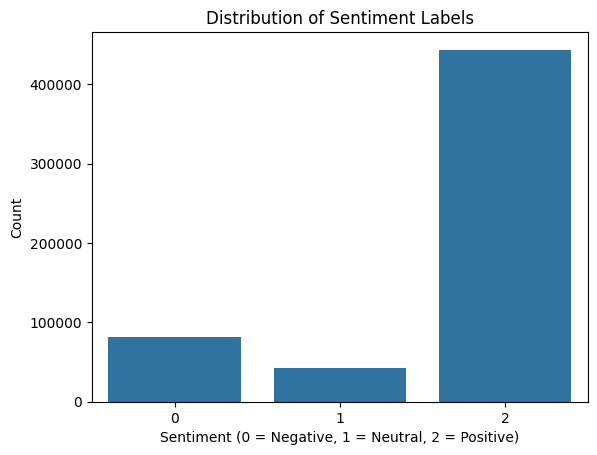

In [ ]:
def plot_sent_labels_count(data, title=None):
    sns.countplot(data=data, x='label')
    plt.title(title)
    plt.xlabel('Sentiment (0 = Negative, 1 = Neutral, 2 = Positive)')
    plt.ylabel('Count')
    plt.show()

plot_sent_labels_count(data=df, title='Distribution of Sentiment Labels')

Undersampling Positive Sentiments

In [ ]:
X, y = df[['Text']].to_numpy(), df[['label']].to_numpy()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='not minority')

X_resampled, y_resampled = undersample.fit_resample(X, y)

In [ ]:
X_df_resampled = pd.Series(X_resampled.flatten(), name='Text')
y_df_resampled = pd.Series(y_resampled.flatten(), name='label')

resampled_df = pd.concat([X_df_resampled, y_df_resampled], axis=1)

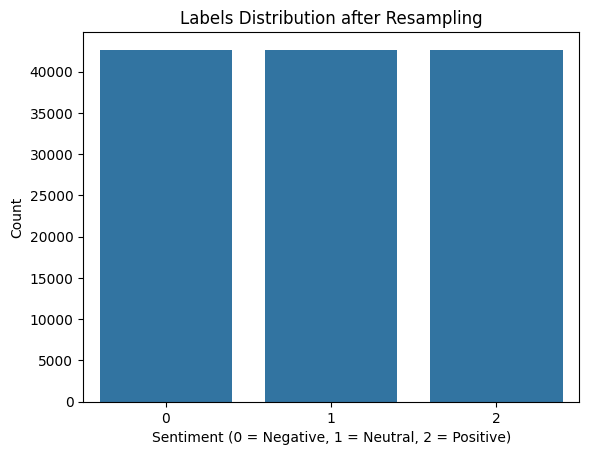

In [ ]:
plot_sent_labels_count(data=resampled_df, title='Labels Distribution after Resampling')

plotting top words appear in each sentiment

In [ ]:
import re
from bs4 import BeautifulSoup

# filtering dataset for negative & postive sentiments
df_filtered = resampled_df[resampled_df['label'].isin([0, 2])]

def preprocess_text(text):
    # Remove HTML tags like <br>
    text = BeautifulSoup(text, "html.parser").get_text()

    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/numbers

    return text

df_filtered['clean_text'] = df_filtered['Text'].apply(preprocess_text)

/tmp/ipython-input-3508809209.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['clean_text'] = df_filtered['Text'].apply(preprocess_text)


In [ ]:
# splitting data by labels
positive_texts = df_filtered[df_filtered["label"] == 2]['clean_text']
negative_texts = df_filtered[df_filtered["label"] == 0]['clean_text']

In [ ]:
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
vectorizer.fit(df_filtered['clean_text'])

pos_matrix = vectorizer.transform(positive_texts)
neg_matrix = vectorizer.transform(negative_texts)

# get word frequencies
pos_freq = pos_matrix.sum(axis=0).A1
neg_freq = neg_matrix.sum(axis=0).A1

words = vectorizer.get_feature_names_out()

# create DataFrames
pos_df = pd.DataFrame({'word': words, 'frequency': pos_freq})
neg_df = pd.DataFrame({'word': words, 'frequency': neg_freq})

top_pos = pos_df.sort_values(by='frequency', ascending=False).head(20)
top_neg = neg_df.sort_values(by='frequency', ascending=False).head(20)

/tmp/ipython-input-3702955038.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pos, x="frequency", y="word", palette='Greens_r')
/tmp/ipython-input-3702955038.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_neg, x="frequency", y="word", palette='Reds_r')


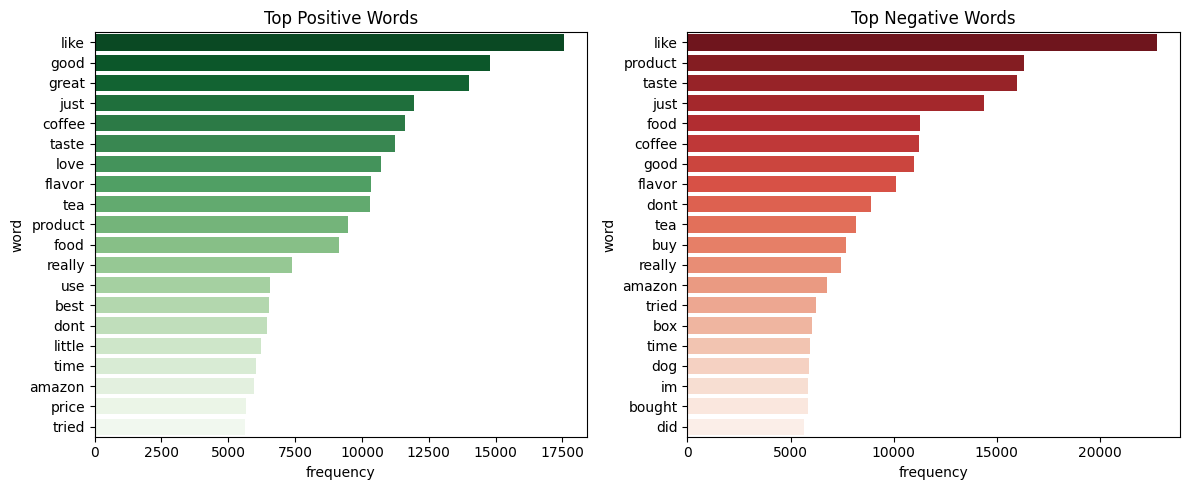

In [ ]:
plt.figure(figsize=(12, 5))

# plot positive words
plt.subplot(1, 2, 1)
sns.barplot(data=top_pos, x="frequency", y="word", palette='Greens_r')
plt.title('Top Positive Words')

# plot negative words
plt.subplot(1, 2, 2)
sns.barplot(data=top_neg, x="frequency", y="word", palette='Reds_r')
plt.title('Top Negative Words')

plt.tight_layout()
plt.show()

#Model Training

In [ ]:
import json

def save_history(model_history ,path):
    with open(path, 'w') as f:
        json.dump(model_history.history, f)

def load_file(file):
    with open(file, 'r') as f:
        return json.load(f)

In [ ]:
# Train vs (Val+Test)
train_data, val_test = train_test_split(resampled_df, test_size=0.3, random_state=42)

# Validation vs Test (from val_test only)
val_data, test_data = train_test_split(val_test, test_size=0.5, random_state=42)

##Naive Bayes

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')

def preprocess_text(series : pd.Series) -> pd.Series:
    # convert texts to lower case
    series = series.str.lower()

    # remove punctuations
    translator = str.maketrans('','', string.punctuation)
    series = series.str.translate(translator)

    # remove stopwords, stem and tokenize
    stopwords_set = set(stopwords.words("english"))
    stemmer = PorterStemmer()

    def process_text(text):
        # tokenize words
        tokens = nltk.word_tokenize(text)

        # stem words
        stem_tokens = [stemmer.stem(token) for token in tokens if token not in stopwords_set]

        return ' '.join(stem_tokens)

    return series.apply(process_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
preprocessed_series = preprocess_text(train_data["Text"])

In [ ]:
preprocessed_train = pd.concat([preprocessed_series, train_data["label"]], axis=1)
preprocessed_train = preprocessed_train.reset_index(drop=True)
preprocessed_train

,Text,label
0,tea strang tast enjoy buy passionfruit flavor ...,0
1,first tea starbuck order use home love strong ...,2
2,fairli decent commerci berber mixtur fair bit ...,1
3,fan neuro drink drink help weight loss energi ...,1
4,use good product small piec light tuna through...,0
...,...,...
89539,husband cancel save subscrib parisian night sw...,2
89540,yeahbr came packag candi paper board packag wi...,2
89541,first impress runni infact splash floor open j...,0
89542,made potato bread great result hodgson breadmi...,0


In [ ]:
save_path = "/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/preprocessed_train.pkl"

In [ ]:
# save the preprocessed data to drive
preprocessed_train.to_pickle(save_path)

In [ ]:
# loading the preprocessed data
preprocessed_train = pd.read_pickle(save_path)
preprocessed_train.head()

,Text,label
0,tea strang tast enjoy buy passionfruit flavor ...,0
1,first tea starbuck order use home love strong ...,2
2,fairli decent commerci berber mixtur fair bit ...,1
3,fan neuro drink drink help weight loss energi ...,1
4,use good product small piec light tuna through...,0


### Modeling

Prepare Data for Naive Bayes

In [ ]:
cv = CountVectorizer()

X_train, y_train = cv.fit_transform(preprocessed_train["Text"]), preprocessed_train["label"]

Train Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

##BERT Model

In [ ]:
model_id="distilbert-base-uncased"
# model_id="google-bert/bert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

###Preparing Data for BERT Model

tokenize data

In [ ]:
def preprocess_tokenizer(examples):
    return tokenizer(examples["Text"], padding=True, truncation=True)

In [ ]:
# Convert to Hugging Face Dataset
hf_train_ds = Dataset.from_pandas(train_data)
hf_val_ds = Dataset.from_pandas(val_data)

# Tokenize with batching
train_tokenized = hf_train_ds.map(preprocess_tokenizer, batched=True)
val_tokenized = hf_val_ds.map(preprocess_tokenizer, batched=True)

Map:   0%|          | 0/89544 [00:00<?, ? examples/s]

Map:   0%|          | 0/19188 [00:00<?, ? examples/s]

In [ ]:
train_tokenized

Dataset({
    features: ['Text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 89544
})

In [ ]:
# Calculating tokens length
token_lengths = []

for token in train_tokenized["Text"]:
    token_lengths.append(len(token))

Text(0.5, 0, 'Tokens Length')

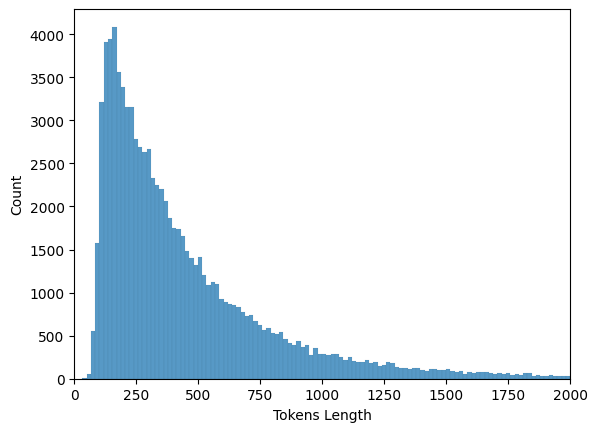

In [ ]:
# Plotting tokens lengths
sns.histplot(token_lengths)
plt.xlim([0, 2000])
plt.xlabel("Tokens Length")

###Modeling

In [ ]:
model=DistilBertForSequenceClassification.from_pretrained(model_id,num_labels=3)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training

In [ ]:
output_dir = "/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/distillbert_sentiment_pytorch_checkpoints"

train_args = TrainingArguments(
    # General Arguments
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    # Checkpoint arguments
    evaluation_strategy="steps",
    eval_steps=2000,
    save_strategy="steps",
    save_steps=2000,
    save_total_limit=3,

    # other arguments
    logging_strategy="steps",
    logging_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [ ]:
# Create the trainer
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

# trainer.train()
trainer.train(resume_from_checkpoint=True)

/tmp/ipython-input-1628930877.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mahmoudmahmoud5735 (mahmoudmahmoud5735-cairo-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy
14000,0.294000,0.426863,0.861684
16000,0.265300,0.445899,0.864603


TrainOutput(global_step=16791, training_loss=0.08082817295281884, metrics={'train_runtime': 4018.7144, 'train_samples_per_second': 66.845, 'train_steps_per_second': 4.178, 'total_flos': 3.558561684339917e+16, 'train_loss': 0.08082817295281884, 'epoch': 3.0})

### Load the Model

In [ ]:
model_checkpoint_path = "/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/distillbert_sentiment_pytorch_checkpoints/checkpoint-16791"
# load the model
model = DistilBertForSequenceClassification.from_pretrained(model_checkpoint_path)
# load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained(model_checkpoint_path)

### Test the Model

In [ ]:
bert_classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use cpu


In [ ]:
bert_classifier("I love this product!")

[{'label': 'LABEL_2', 'score': 0.9978620409965515}]

In [ ]:
bert_classifier("I hate this product")

[{'label': 'LABEL_0', 'score': 0.9977874755859375}]

In [ ]:
bert_classifier("Not bad, not good either")

[{'label': 'LABEL_1', 'score': 0.9344800710678101}]

## Models Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(preds, title="Confusion Matrix"):
    cm = confusion_matrix(test_data["label"], preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap="Blues", ax=ax, colorbar=False)

    # title
    ax.set_title(title, fontsize=14)

    # Customize ticks
    classes = ["Neg", "Neut", "Pos"]
    if classes is not None:
        ax.set_xticks(range(len(classes)))
        ax.set_yticks(range(len(classes)))
        ax.set_xticklabels(classes, fontsize=10, rotation=45)  # rotate for readability
        ax.set_yticklabels(classes, fontsize=10)

    plt.show()

### Evaluate Naive Bayes

In [ ]:
from sklearn.pipeline import Pipeline

# create a prediction pipeline for naive bayes
nb_pipeline = Pipeline([
    ("preprocessor", FunctionTransformer(preprocess_text)),
    ("vectorizer", cv),
    ("classifier", nb)
])

In [ ]:
# predict the test data
preds = nb_pipeline.predict(test_data["Text"])

In [ ]:
# calculate naive bayes accuraccy score
nb_accuracy_score = accuracy_score(test_data["label"], preds)
print("Naive Bayes accuracy score: ",nb_accuracy_score)

Naive Bayes accuracy score:  0.6883989993746091


In [ ]:
# make a naive bayes report
nb_report = classification_report(test_data["label"], preds, output_dict=True)

# convert report to df for visualization purposes
nb_report_df = pd.DataFrame(nb_report).transpose()
nb_report_df

,precision,recall,f1-score,support
0,0.703061,0.686278,0.694568,6493.000000
1,0.599731,0.634579,0.616663,6316.000000
2,0.769418,0.743847,0.756416,6379.000000
accuracy,0.688399,0.688399,0.688399,0.688399
macro avg,0.690736,0.688234,0.689216,19188.000000
weighted avg,0.691108,0.688399,0.689486,19188.000000


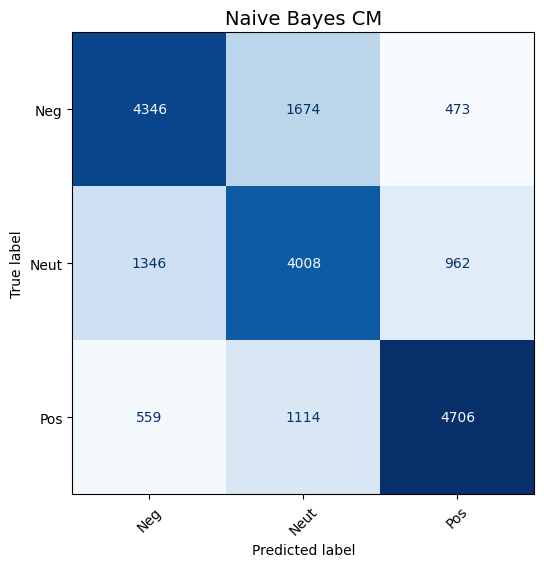

In [ ]:
plot_confusion_matrix(preds, title="Naive Bayes CM")

### Evaluate BERT

In [ ]:
# create a BERT pipeline
bert_pipeline = pipeline("sentiment-analysis",
                         model=model,tokenizer=tokenizer,
                         truncation=True, batch_size=16)

Device set to use cuda:0


In [ ]:
# convert test text series to a python list
test_data_lst = test_data["Text"].tolist()

# predict test data with BERT
preds = bert_pipeline(test_data_lst)

In [ ]:
def format_preds(preds):
    labels = []

    for pred in preds:
        # reformat labels
        if pred['label'] == 'LABEL_0':
            labels.append(0)
        elif pred['label'] == 'LABEL_1':
            labels.append(1)
        elif pred['label'] == 'LABEL_2':
            labels.append(2)

    return labels

In [ ]:
reformatted_preds = format_preds(preds)

In [ ]:
# calculate BERT accuraccy score
bert_accuracy_score = accuracy_score(test_data["label"], reformatted_preds)
print("BERT accuracy score: ",bert_accuracy_score)

BERT accuracy score:  0.8718469877006463


In [ ]:
# make a report for BERT model
bert_report = classification_report(test_data["label"], reformatted_preds, output_dict=True)

# convert report to df for visualization purposes
bert_report_df = pd.DataFrame(bert_report).transpose()
bert_report_df

,precision,recall,f1-score,support
0,0.852701,0.916525,0.883462,6493.000000
1,0.848538,0.771691,0.808292,6316.000000
2,0.913225,0.925537,0.919340,6379.000000
accuracy,0.871847,0.871847,0.871847,0.871847
macro avg,0.871488,0.871251,0.870365,19188.000000
weighted avg,0.871452,0.871847,0.870646,19188.000000


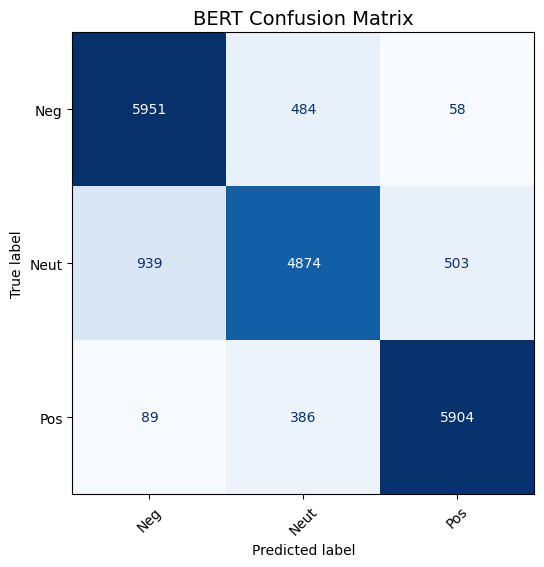

In [ ]:
plot_confusion_matrix(reformatted_preds, title="BERT Confusion Matrix")

### Compare Models

In [ ]:
def compare_models(report1, report2, model1_name, model2_name):
    df1 = report1[['precision', 'recall', 'f1-score']]
    df2 = report2[['precision', 'recall', 'f1-score']]

    # Only keep actual classes (drop accuracy/avg rows if you want class-wise comparison only)
    df1 = df1.iloc[:-3]
    df2 = df2.iloc[:-3]

    # Combine into one DataFrame for plotting
    df_compare = pd.concat([df1.add_suffix(f"_{model1_name}"), df2.add_suffix(f"_{model2_name}")], axis=1)

    # Plot grouped bar chart
    ax = df_compare.plot(kind="bar", figsize=(10,6))
    plt.title(f"Performance Comparison: {model1_name} vs {model2_name}")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)  # scores are between 0 and 1
    plt.legend(loc="lower right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    return df_compare

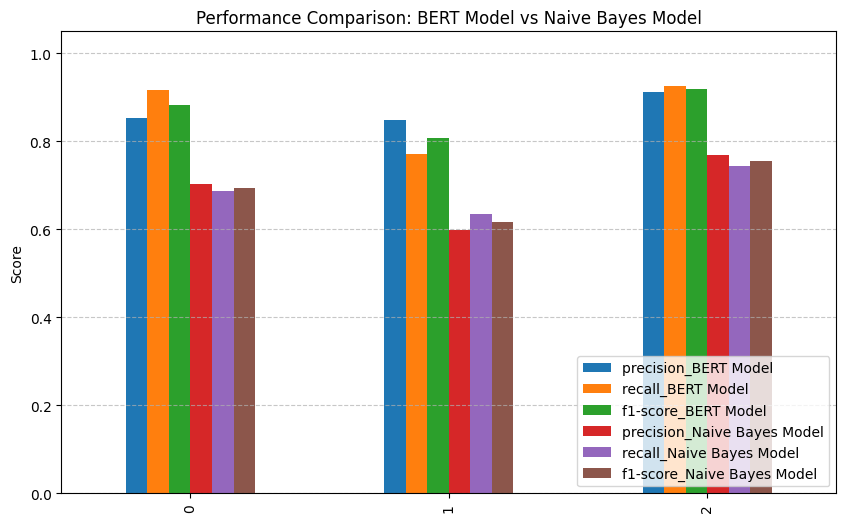

,precision_BERT Model,recall_BERT Model,f1-score_BERT Model,precision_Naive Bayes Model,recall_Naive Bayes Model,f1-score_Naive Bayes Model
0,0.852701,0.916525,0.883462,0.703061,0.686278,0.694568
1,0.848538,0.771691,0.808292,0.599731,0.634579,0.616663
2,0.913225,0.925537,0.919340,0.769418,0.743847,0.756416


In [ ]:
# plot a groupted bar chart to compare BERT against NB
compare_models(
    report1=bert_report_df,
    report2=nb_report_df,
    model1_name="BERT Model",
    model2_name="Naive Bayes Model"
)

# Deploy with Gradio

In [ ]:
!pip install gradio -q

## Load the Model and the Tokenizer

In [ ]:
import gradio as gr
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

final_model_path = "/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/distillbert_sentiment_pytorch_checkpoints/checkpoint-16791"
model = DistilBertForSequenceClassification.from_pretrained(final_model_path)
tokenizer = DistilBertTokenizerFast.from_pretrained(final_model_path)
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
model.to(device)

print("Model and Tokenizer loaded successfully for deployment.")

Model and Tokenizer loaded successfully for deployment.


In [ ]:
def predict_sentiment(text):
    """
    A Prediction funcion that takes raw text
    and return a dictionary of class probabilities.
    """

    # tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # move input tensors to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model predictions (logits)
    with torch.no_grad():
        logits = model(**inputs).logits

    # Convert logits to probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    # Get the probabilities as a list and format the output
    confidences = probabilities[0].tolist()
    label_map = ["Negative", "Neutral", "Positive"]

    # create a dictionary of labels to confidences
    output_dict = {label: conf for label, conf in zip(label_map, confidences)}

    return output_dict

## Create and Launch the Gradio UI

In [ ]:
app = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(placeholder="Enter a sentence here...", label="Input Text"),
    outputs=gr.Label(label="Predicted Sentiments"),
    title="Sentiment Analysis with DistilBERT",
    description="Enter any English text to see the predicted sentiment. This model was fine-tuned on a custom dataset.",
    examples=[
        ["The movie was fantastic! I would recommend it to everyone."],
        ["I'm not sure how I feel about this product."],
        ["This was the worst customer service experience I have ever had."]
    ]
)

# Launch the app
app.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://92ba7220737a744b39.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
